<a href="https://colab.research.google.com/github/asishpattnaik1/CE888-Assignment-1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import important libraries

In [24]:
import pandas as pd
import numpy as np
import urllib.request
import csv
import matplotlib.pyplot as plt

In [25]:
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm

In [26]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

My chosen datasets are: **Offensive language identification** , **Hate speech detection** and **Sentiment Analysis.**

Loading Hate Datasets 

In [28]:
#loading Hate speech data
#Loading Train dataset
hate_train_text = pd.read_csv("/content/tweeteval/datasets/hate/train_text.txt", sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_train_text.columns= ["tweet_text"]
hate_train_label = pd.read_csv("/content/tweeteval/datasets/hate/train_labels.txt",encoding='utf-8',sep="\n", header=None)
hate_train_label.columns= ["tweet_label"]

# Loading Validation dataset
hate_val_text = pd.read_csv("/content/tweeteval/datasets/hate/val_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_val_text.columns= ["tweet_text"]
hate_val_label = pd.read_csv("/content/tweeteval/datasets/hate/val_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_val_label.columns= ["tweet_label"]

# Loading Test dataset
hate_test_text = pd.read_csv("/content/tweeteval/datasets/hate/test_text.txt",sep="\t", quoting=csv.QUOTE_NONE, skip_blank_lines=False, header=None)
hate_test_text.columns= ["tweet_text"]
hate_test_label = pd.read_csv("/content/tweeteval/datasets/hate/test_labels.txt",encoding='utf-8',sep="\t", header=None)
hate_test_label.columns= ["tweet_label"]

# Loading Map
hate_map = pd.read_csv("/content/tweeteval/datasets/hate/mapping.txt",encoding='utf-8',sep="\t", header=None)
hate_map.columns= ["tweet_label","isHate"]


Loading Offensive Datasets

In [29]:
#loading offensive data
#Loading Train dataset
off_train_text = pd.read_csv("/content/tweeteval/datasets/offensive/train_text.txt",encoding='utf-8',sep="\t", header=None)
off_train_text.columns= ["tweet_text"]
off_train_label = pd.read_csv("/content/tweeteval/datasets/offensive/train_labels.txt",encoding='utf-8',sep="\t", header=None)
off_train_label.columns= ["tweet_label"]

# Loading Validation dataset
off_val_text = pd.read_csv("/content/tweeteval/datasets/offensive/val_text.txt",encoding='utf-8',sep="\t", header=None)
off_val_text.columns= ["tweet_text"]
off_val_label = pd.read_csv("/content/tweeteval/datasets/offensive/val_labels.txt",encoding='utf-8',sep="\t", header=None)
off_val_label.columns= ["tweet_label"]

# Loading Test dataset
off_test_text = pd.read_csv("/content/tweeteval/datasets/offensive/test_text.txt",encoding='utf-8',sep="\t", header=None)
off_test_text.columns= ["tweet_text"]
off_test_label = pd.read_csv("/content/tweeteval/datasets/offensive/test_labels.txt",encoding='utf-8',sep="\t", header=None)
off_test_label.columns= ["tweet_label"]

#loading Map Dataset
off_map = pd.read_csv("/content/tweeteval/datasets/offensive/mapping.txt",encoding='utf-8',sep="\t", header=None)
off_map.columns= ["tweet_label","offensive"]


Loading Sentiment Datasets

In [82]:
#loading Sentiment data
#Loading Train dataset
sen_train_text = pd.read_csv("/content/tweeteval/datasets/sentiment/train_text.txt",encoding='utf-8',sep="\t", header=None)
sen_train_text.columns= ["tweet_text"]
sen_train_label = pd.read_csv("/content/tweeteval/datasets/sentiment/train_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_train_label.columns= ["tweet_label"]

# Loading Validation dataset
sen_val_text = pd.read_csv("/content/tweeteval/datasets/sentiment/val_text.txt",encoding='utf-8',sep="\t", header=None)
sen_val_text.columns= ["tweet_text"]
sen_val_label = pd.read_csv("/content/tweeteval/datasets/sentiment/val_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_val_label.columns= ["tweet_label"]

# Loading Test dataset
sen_test_text = pd.read_csv("/content/tweeteval/datasets/sentiment/test_text.txt",encoding='utf-8',sep="\t", header=None)
sen_test_text.columns= ["tweet_text"]
sen_test_label = pd.read_csv("/content/tweeteval/datasets/sentiment/test_labels.txt",encoding='utf-8',sep="\t", header=None)
sen_test_label.columns= ["tweet_label"]

#Loading Map dataset
sen_map = pd.read_csv("/content/tweeteval/datasets/sentiment/mapping.txt",encoding='utf-8',sep="\t", header=None)
sen_map.columns= ["tweet_label","sentiment"]



Common Pre-Processing of all the datasets

In [83]:
def clean_tweet(text):
  # "- Removing HTML tags
  #   - Removing punctuation
  #   - Lowering text
  #   "
  # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text


In [84]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [85]:
# Source of code: https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert/notebook

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# **Hate Detection**
## Preprocess

In [86]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_hate_train = pd.concat([hate_train_text,hate_train_label], axis=1)
df_hate_val = pd.concat([hate_val_text,hate_val_label], axis=1)
df_hate_test = pd.concat([hate_test_text,hate_test_label], axis=1)

In [87]:
hate_combo_train = pd.merge(df_hate_train,hate_map, on='tweet_label')
hate_combo_val = pd.merge(df_hate_val,hate_map, on='tweet_label')
hate_combo_test = pd.merge(df_hate_test,hate_map, on='tweet_label')

hate_train_val = pd.concat([hate_combo_train, hate_combo_val])

#checking total nan values/ empty rows
total =0
for n in pd.isna(hate_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

8

In [88]:
hate_train_val.dropna(inplace=True) #dropping the empty tweets, total 8, as they were included during the reading part
hate_combo_test.dropna(inplace=True)

In [89]:
train_hate = hate_train_val.copy()
train_hate['text_clean'] = train_hate['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [91]:
#removing workds like user and amp in clean tweets
train_hate['text_clean'] = train_hate['text_clean'].str.replace('user','')
train_hate['text_clean'] = train_hate['text_clean'].str.replace('amp','')
train_hate['text_clean'] = train_hate['text_clean'].str.replace('@','')
train_hate

,tweet_text,tweet_label,isHate,text_clean
0,@user nice new signage. Are you not concerned ...,0,not-hate,nice new signage. Are you not concerned by Be...
1,Hysterical woman like @user,0,not-hate,Hysterical woman like
2,Me flirting- So tell me about your father...,0,not-hate,Me flirting- So tell me about your father...
3,The Philippine Catholic bishops' work for migr...,0,not-hate,The Philippine Catholic bishops' work for migr...
4,When cuffin season is finally over,0,not-hate,When cuffin season is finally over
...,...,...,...,...
995,"shut the fuck up you know youre that bitch, wh...",1,hate,"shut the fuck up you know youre that bitch, wh..."
996,Where the fuck is your face scary hoe? Dont be...,1,hate,Where the fuck is your face scary hoe? Dont be...
997,Pass #MeritBased Immigration. Kill #ChainMigra...,1,hate,Pass #MeritBased Immigration. Kill #ChainMigra...
998,I usually dont hate people but I actually hate...,1,hate,I usually dont hate people but I actually hate...


In [92]:
# Hate tweet
print("Hate Tweet example :",hate_train_val[hate_train_val['isHate']=='hate']['tweet_text'].values[0])
#Not-Hate Tweet 
print("Not Hate Tweet example :",hate_train_val[hate_train_val['isHate']=='not-hate']['tweet_text'].values[0])

Hate Tweet example : A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎 
Not Hate Tweet example : @user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you… 


**Visualization**

In [121]:
from google.colab import files
hate_yes = train_hate[train_hate['isHate'] == 'hate']['text_clean']
hate_no = train_hate[train_hate['isHate'] == 'not-hate']['text_clean']

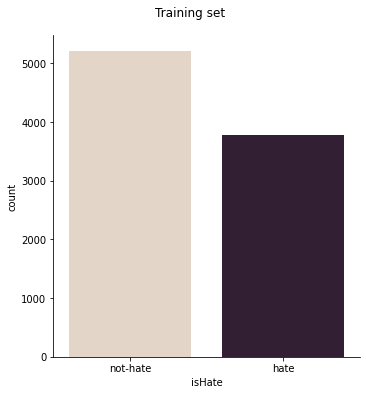

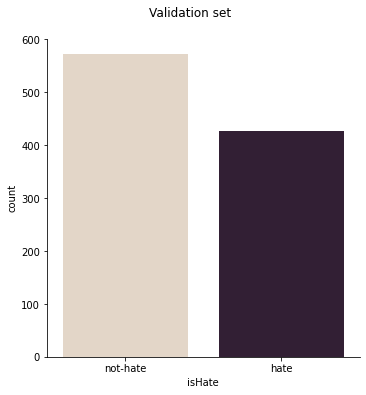

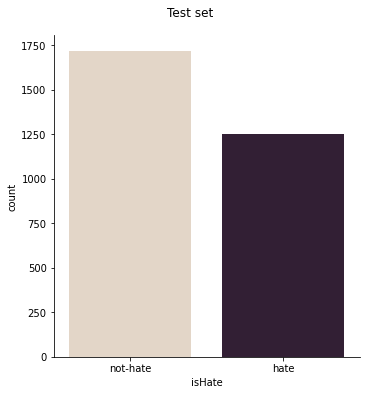

In [95]:
g = (sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("hate_train.png")
# files.download("hate_train.png")
plt.show()

v = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("hate_val.png")
# files.download("hate_val.png")
plt.show()

t = sns.catplot(x="isHate", kind="count", palette="ch:.20", data=hate_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("hate_test.png")
# files.download("hate_test.png")
plt.show()

wordcloud

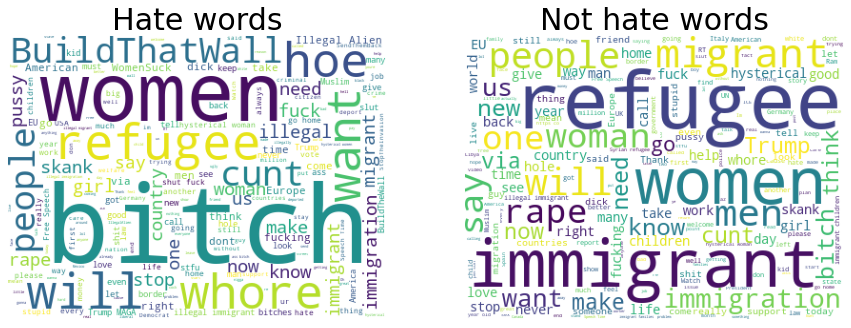

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=400,
                        height=300).generate(" ".join(hate_yes))
# wordcloud1.to_file('hate_cloud.png')
# files.download('hate_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Hate words',fontsize=30);

wordcloud2 = WordCloud( background_color='white',
                        width=400,
                        height=300).generate(" ".join(hate_no))
# wordcloud2.to_file('not_hate_cloud.png')
# files.download('not_hate_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not hate words',fontsize=30);

Top Hate and not hate word  Bar graph

In [97]:
top_hate_words = get_top_n_words(hate_yes)
top_nonHate_words = get_top_n_words(hate_no)


s1 = [x[0] for x in top_hate_words[:20]]
s2 = [x[1] for x in top_hate_words[:20]]

a1 = [x[0] for x in top_nonHate_words[:20]]
a2 = [x[1] for x in top_nonHate_words[:20]]

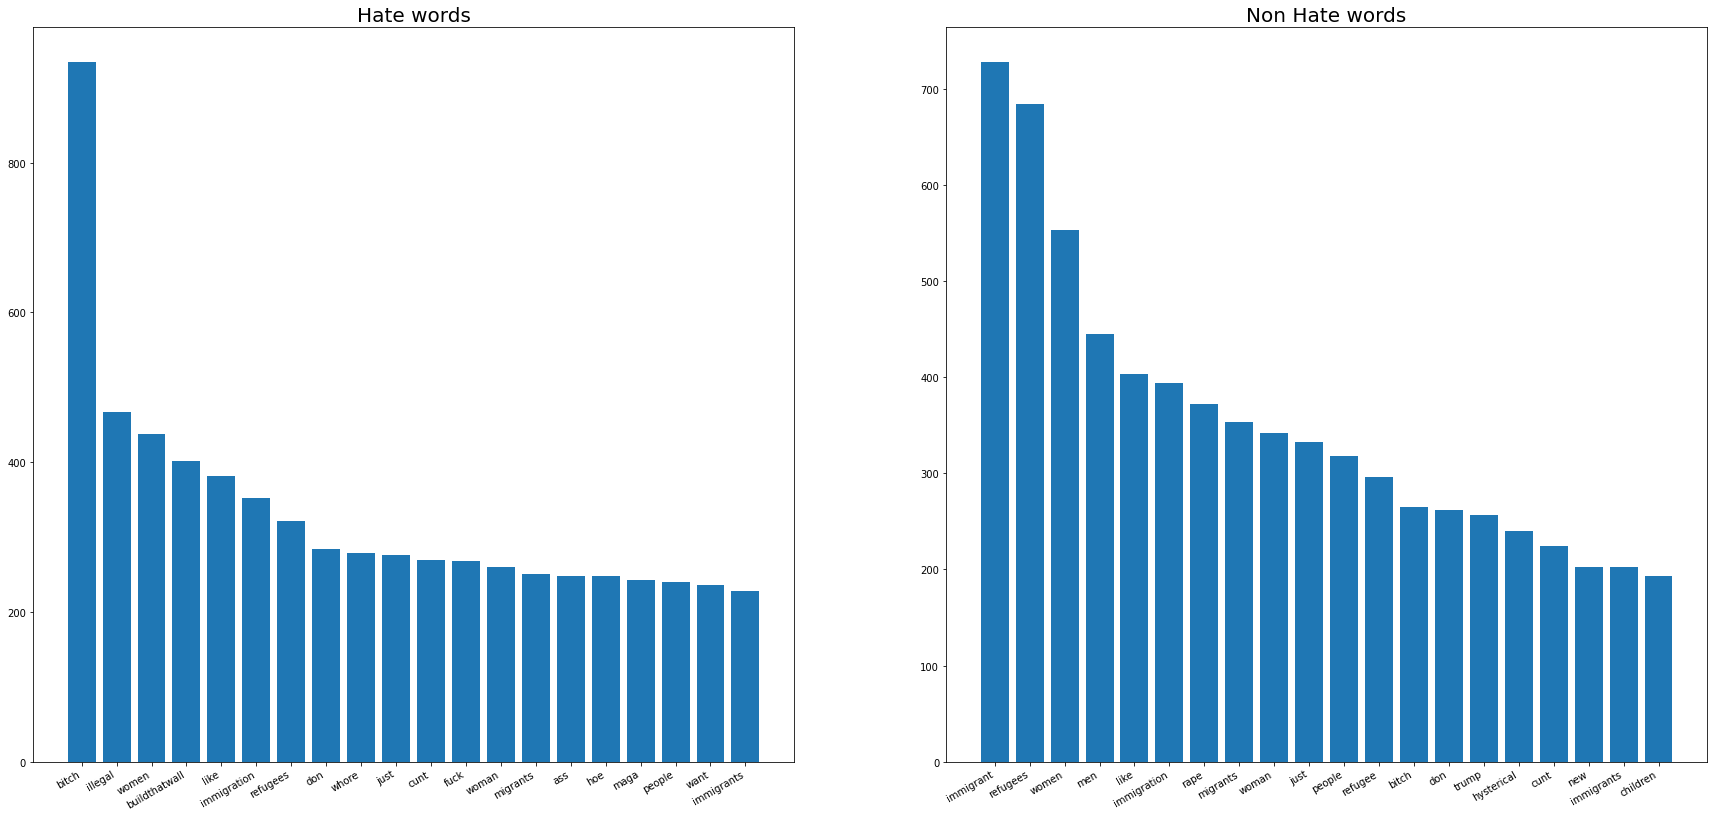

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(s1, s2)


ax1.set_title('Hate words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Non Hate words',fontsize=20);
fig.autofmt_xdate()

#**Offensive Dataset**
## Preprocess

In [99]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_off_train = pd.concat([off_train_text,off_train_label], axis=1)
df_off_val = pd.concat([off_val_text,off_val_label], axis=1)
df_off_test = pd.concat([off_test_text,off_test_label], axis=1)

In [100]:
off_combo_train = pd.merge(df_off_train,off_map, on='tweet_label')
off_combo_val = pd.merge(df_off_val,off_map, on='tweet_label')
off_combo_test = pd.merge(df_off_test,off_map, on='tweet_label')

In [101]:
off_train_val = pd.concat([off_combo_train,off_combo_val])

In [102]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(off_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

0

In [103]:
train_off = off_train_val.copy()
train_off['text_clean'] = train_off['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [104]:
#removing workds like user and amp in clean tweets
train_off['text_clean'] = train_off['text_clean'].str.replace('user','')
train_off['text_clean'] = train_off['text_clean'].str.replace('amp','')
train_off['text_clean'] = train_off['text_clean'].str.replace('@','')
train_off

,tweet_text,tweet_label,offensive,text_clean
0,@user Bono... who cares. Soon people will unde...,0,not-offensive,Bono... who cares. Soon people will understan...
1,@user Get him some line help. He is gonna be j...,0,not-offensive,Get him some line help. He is gonna be just f...
2,@user @user She is great. Hi Fiona!,0,not-offensive,She is great. Hi Fiona!
3,@user @user @user @user @user @user @user @use...,0,not-offensive,"This is the VetsResistSquadron""..."
4,@user @user Lol. Except he’s the most successf...,0,not-offensive,Lol. Except he’s the most successful preside...
...,...,...,...,...
1319,@user @user @user Weak argument considering -...,1,offensive,Weak argument considering -GOP congressmen...
1320,@user Stop saying this shit you are not going ...,1,offensive,Stop saying this shit you are not going to do...
1321,@user @user @user @user @user Sorry to break i...,1,offensive,Sorry to break it to you but the god of t...
1322,. she. is the most powerful woman on this eart...,1,offensive,. she. is the most powerful woman on this eart...


In [105]:
# offensive tweet
print("Offensive Tweet example :",off_train_val[off_train_val['offensive']=='offensive']['tweet_text'].values[0])
#Not-offensive Tweet 
print("Non offensive Tweet example :",off_train_val[off_train_val['offensive']=='not-offensive']['tweet_text'].values[0])


Offensive Tweet example : @user Eight years the republicans denied obama’s picks. Breitbarters outrage is as phony as their fake president. 
Non offensive Tweet example : @user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen. 


Visualization

In [106]:
#creating different datasets for different classes
off_yes = train_off[train_off['offensive'] == 'offensive']['text_clean']
off_no = train_off[train_off['offensive'] == 'not-offensive']['text_clean']


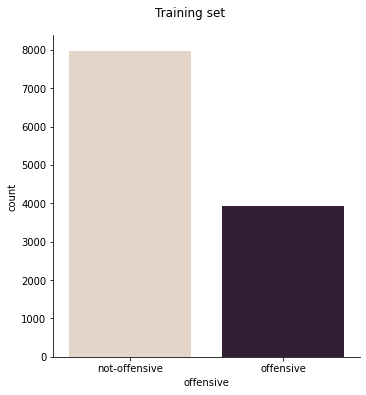

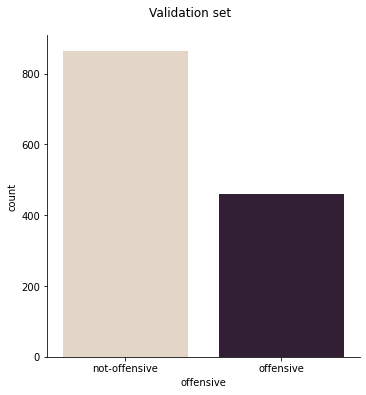

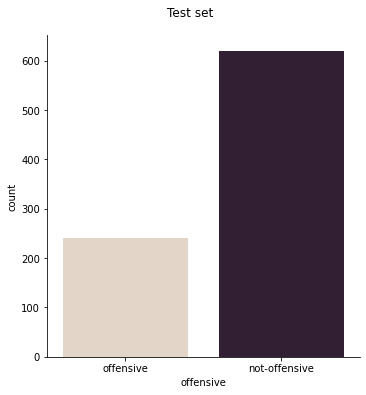

In [107]:
g = (sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_train))
g.fig.suptitle("Training set", y=1.05)
# g.savefig("off_train.png")
# files.download("off_train.png")
plt.show()

v = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("off_val.png")
# files.download("off_val.png")
plt.show()

t = sns.catplot(x="offensive", kind="count", palette="ch:.20", data=off_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("off_test.png")
#files.download("off_test.png")
plt.show()


wordcloud

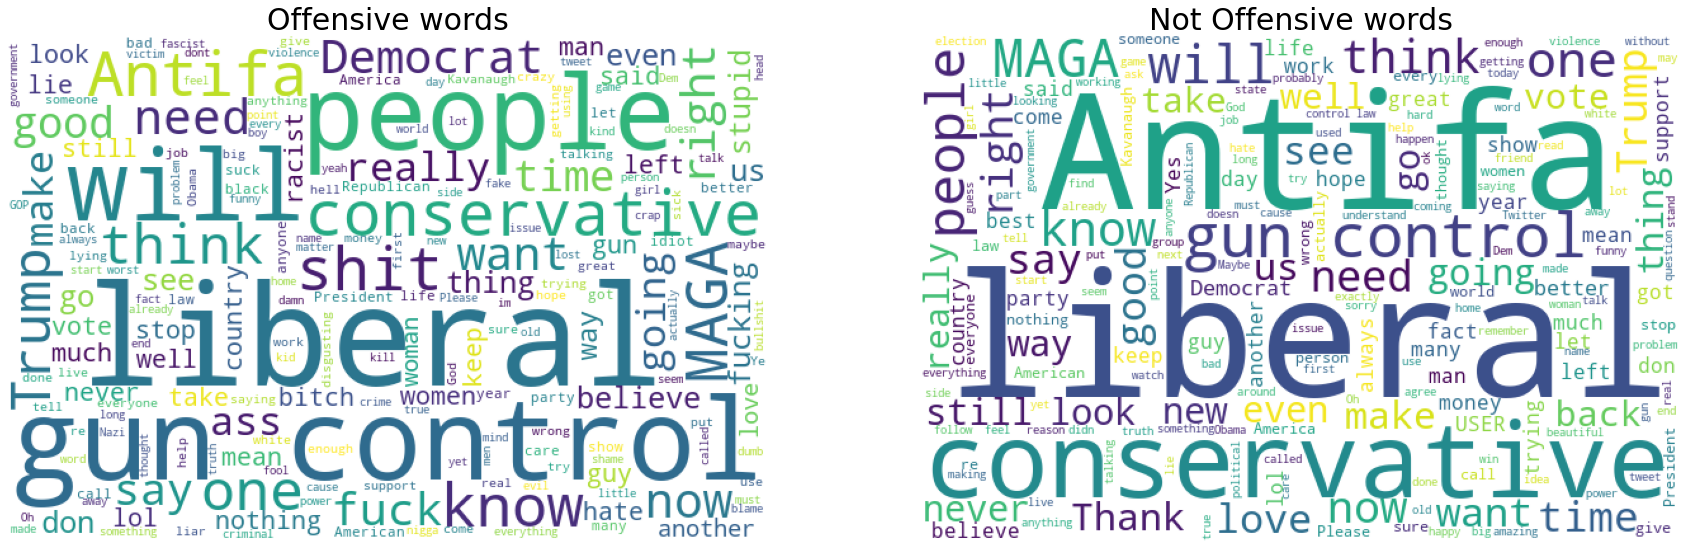

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(off_yes))
# wordcloud1.to_file('off_cloud.png')
# files.download('off_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Offensive words',fontsize=30);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(off_no))
# wordcloud2.to_file('non_off_cloud.png')
# files.download('non_off_cloud.png')
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Not Offensive words',fontsize=30);

 

In [109]:
top_offensive_words = get_top_n_words(off_yes)
top_nonOff_words = get_top_n_words(off_no)


s1 = [x[0] for x in top_offensive_words[:20]]
s2 = [x[1] for x in top_offensive_words[:20]]

a1 = [x[0] for x in top_nonOff_words[:20]]
a2 = [x[1] for x in top_nonOff_words[:20]]



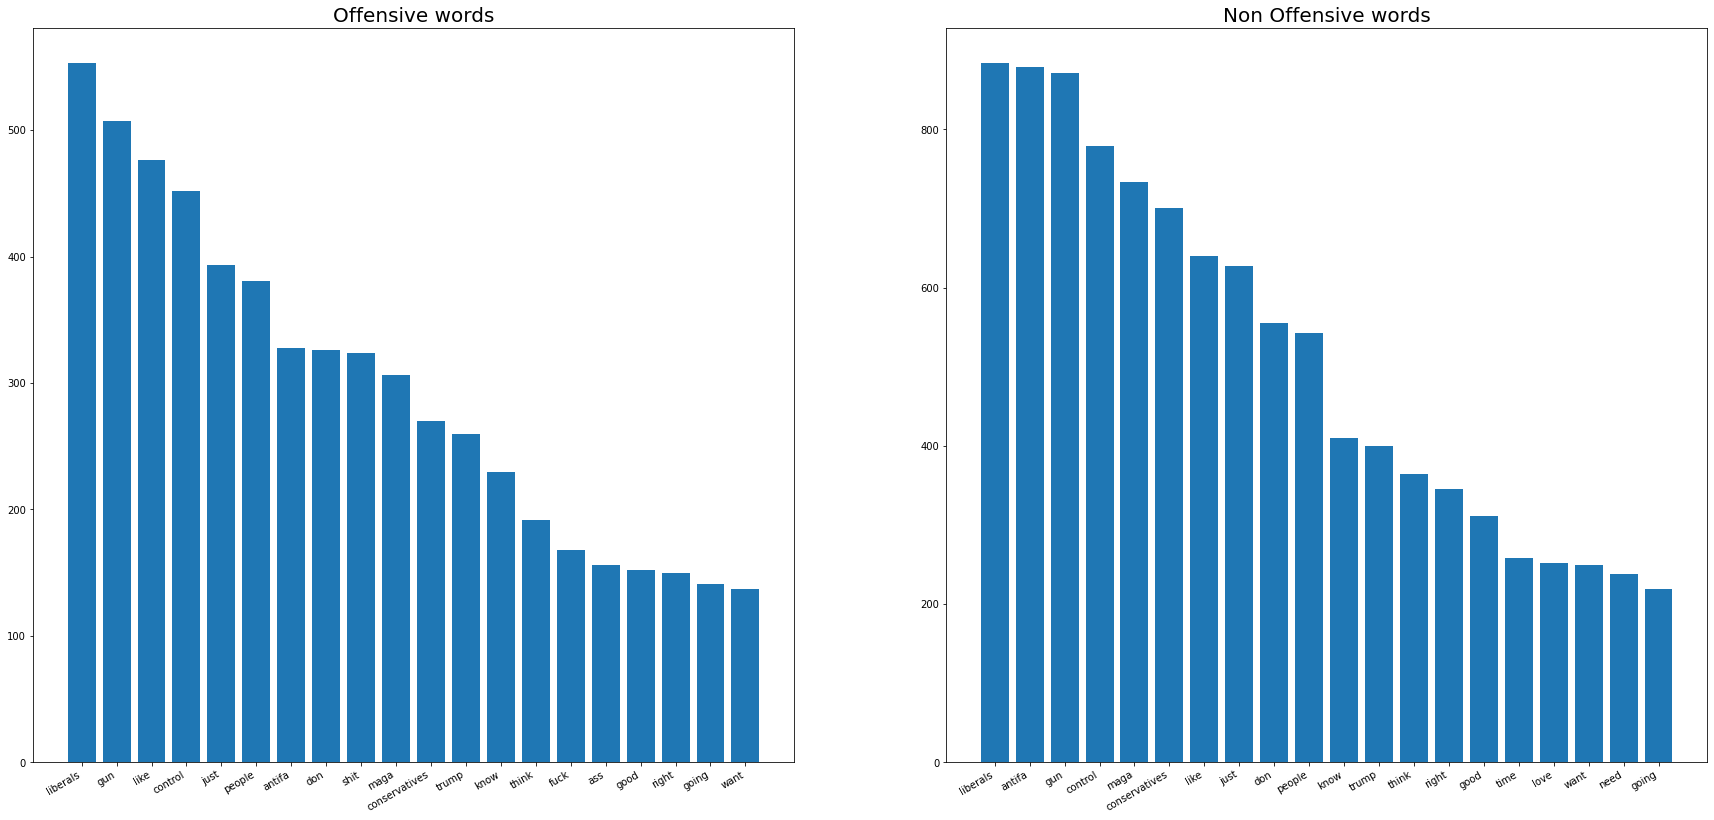

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])
ax1.bar(s1, s2)


ax1.set_title('Offensive words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Non Offensive words',fontsize=20);
fig.autofmt_xdate()





# **Sentiment Dataset**
## Preprocess

In [111]:
#concatenating dataframe to make one dataset each for train, validation and test df
df_sen_train = pd.concat([sen_train_text,sen_train_label], axis=1)
df_sen_val = pd.concat([sen_val_text,sen_val_label], axis=1)
df_sen_test = pd.concat([sen_test_text,sen_test_label], axis=1)

In [112]:
sen_combo_train = pd.merge(df_sen_train,sen_map, on='tweet_label')
sen_combo_val = pd.merge(df_sen_val,sen_map, on='tweet_label')
sen_combo_test = pd.merge(df_sen_test,sen_map, on='tweet_label')

In [113]:
sen_train_val = pd.concat([sen_combo_train,sen_combo_val])

In [114]:
#checking total nan values/ empty rows
total =0
for n in pd.isna(sen_train_val["tweet_text"]):
  if n==True:
    total = total+1
total

9619

In [115]:
sen_train_val.dropna(inplace=True) #dropping the empty tweets, total 9619, as they were included during the reading part
sen_combo_test.dropna(inplace=True)

In [116]:
train_sen = sen_train_val.copy()
train_sen['text_clean'] = train_sen['tweet_text'].apply(str).apply(lambda x: preprocess(x))

In [117]:
#removing workds like user,@ and amp in clean tweets
train_sen['text_clean'] = train_sen['text_clean'].str.replace('user','')
train_sen['text_clean'] = train_sen['text_clean'].str.replace('amp','')
train_sen['text_clean'] = train_sen['text_clean'].str.replace('@','')
train_sen

,tweet_text,tweet_label,sentiment,text_clean
0,QT @user In the original draft of the 7th book...,2,positive,"QT In the original draft of the 7th book, Rem..."
1,@user Alciato: Bee will invest 150 million in ...,2,positive,Alciato: Bee will invest 150 million in Janua...
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive,LIT MY MUM 'Kerry the louboutins I wonder how...
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",2,positive,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ..."
4,"This is the last Sunday w/o football .....,NFL...",2,positive,"This is the last Sunday w/o football .....,NFL..."
...,...,...,...,...
1941,According to Janet Jackson's long time produce...,0,negative,According to Janet Jackson's long time produce...
1942,Monday at Town Ballroom: RICHIE HAWTIN with LO...,0,negative,Monday at Town Ballroom: RICHIE HAWTIN with LO...
1943,Disappointed the Knicks vs Nets game got cance...,0,negative,Disappointed the Knicks vs Nets game got cance...
1944,"\""""@_eryflores: March 16 Luke Bryan is gonna a...",0,negative,"\""""_eryflores: March 16 Luke Bryan is gonna at..."


In [120]:
# negative tweet
print("negative Tweet example :",sen_train_val[sen_train_val['sentiment']=='negative']['tweet_text'].values[0])
#neutral Tweet 
print("neutral Tweet example :",sen_train_val[sen_train_val['sentiment']=='neutral']['tweet_text'].values[0])
#positive tweet
print("positive tweet example  :",sen_train_val[sen_train_val['sentiment']=='positive']['tweet_text'].values[0]) 

negative Tweet example : So disappointed in wwe summerslam! I want to see john cena wins his 16th title 
neutral Tweet example : Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ 
positive tweet example  : QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin 


**Visualization**

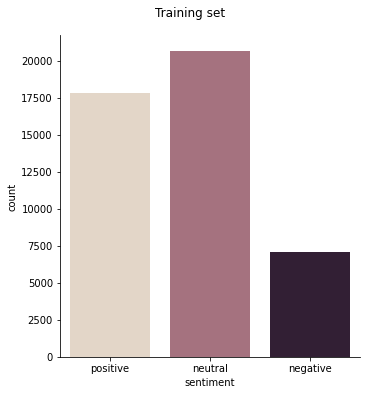

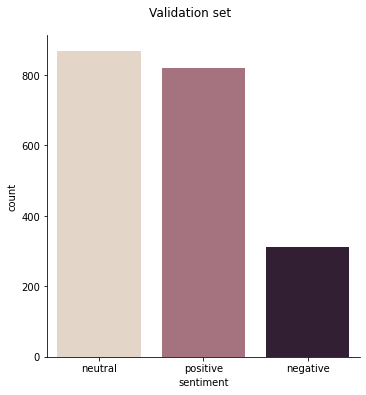

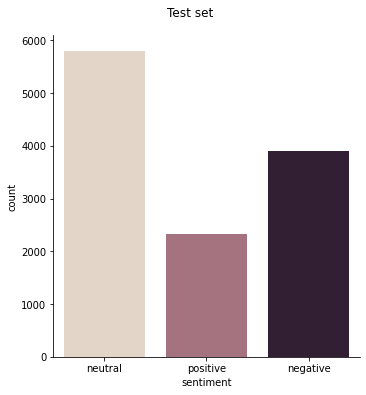

In [131]:
g = (sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_train))
g.fig.suptitle("Training set", y=1.05)
#g.savefig("sen_train1.png")
#files.download("emo_train1.png")
plt.show()

v = sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_val)
v.fig.suptitle("Validation set", y=1.05)
# v.savefig("sen_val.png")
#files.download("sen_val.png")
plt.show()

t = sns.catplot(x="sentiment", kind="count", palette="ch:.20", data=sen_combo_test)
t.fig.suptitle("Test set", y=1.05)
# t.savefig("sen_test.png")
# files.download("sen_test.png")

plt.show()



all the three datasets are similarly unbalanced.

wordcloud

In [133]:
#creating different datasets for different emotions
sen_negative = train_sen[train_sen['sentiment'] == 'negative']['text_clean']
sen_neutral = train_sen[train_sen['sentiment'] == 'neutral']['text_clean']
sen_positive = train_sen[train_sen['sentiment'] == 'positive']['text_clean']

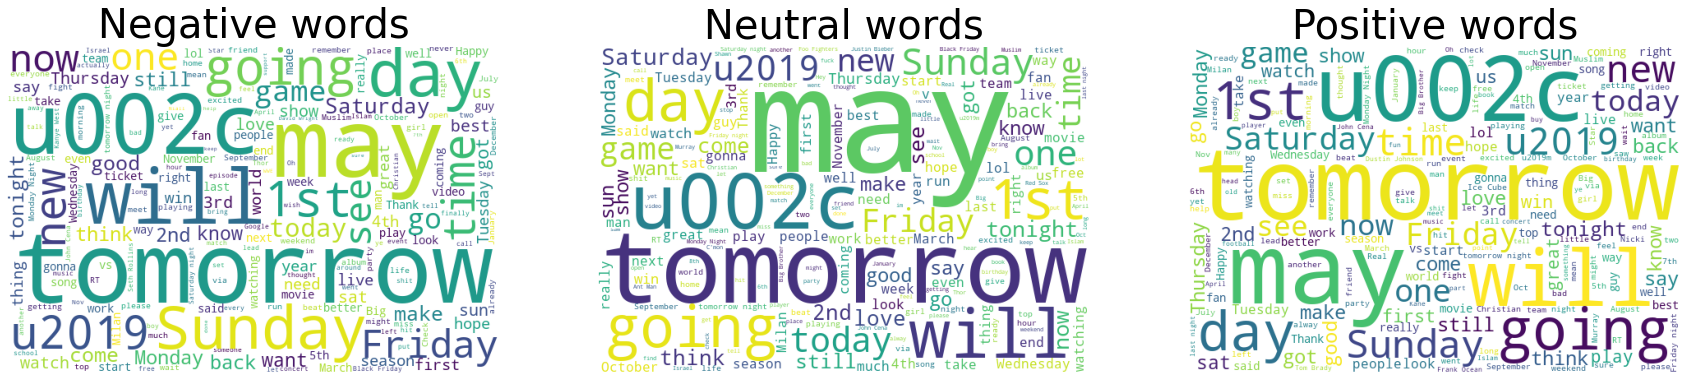

In [137]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_negative))
# wordcloud1.to_file('negative_cloud.png')
# files.download('negative_cloud.png')

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Negative words',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_neutral))
# wordcloud2.to_file('neutral_cloud.png')
# files.download('neutral_cloud.png')

ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Neutral words',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(sen_positive))
# wordcloud3.to_file('positive_cloud.png')
# files.download('positive_cloud.png')

ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Positive words',fontsize=40);
 

In [136]:
top_negative_words = get_top_n_words(sen_negative)
top_neutral_words = get_top_n_words(sen_neutral)
top_positive_words = get_top_n_words(sen_positive)


s1 = [x[0] for x in top_negative_words[:20]]
s2 = [x[1] for x in top_negative_words[:20]]

a1 = [x[0] for x in top_neutral_words[:20]]
a2 = [x[1] for x in top_neutral_words[:20]]

j1 = [x[0] for x in top_positive_words[:20]]
j2 = [x[1] for x in top_positive_words[:20]]


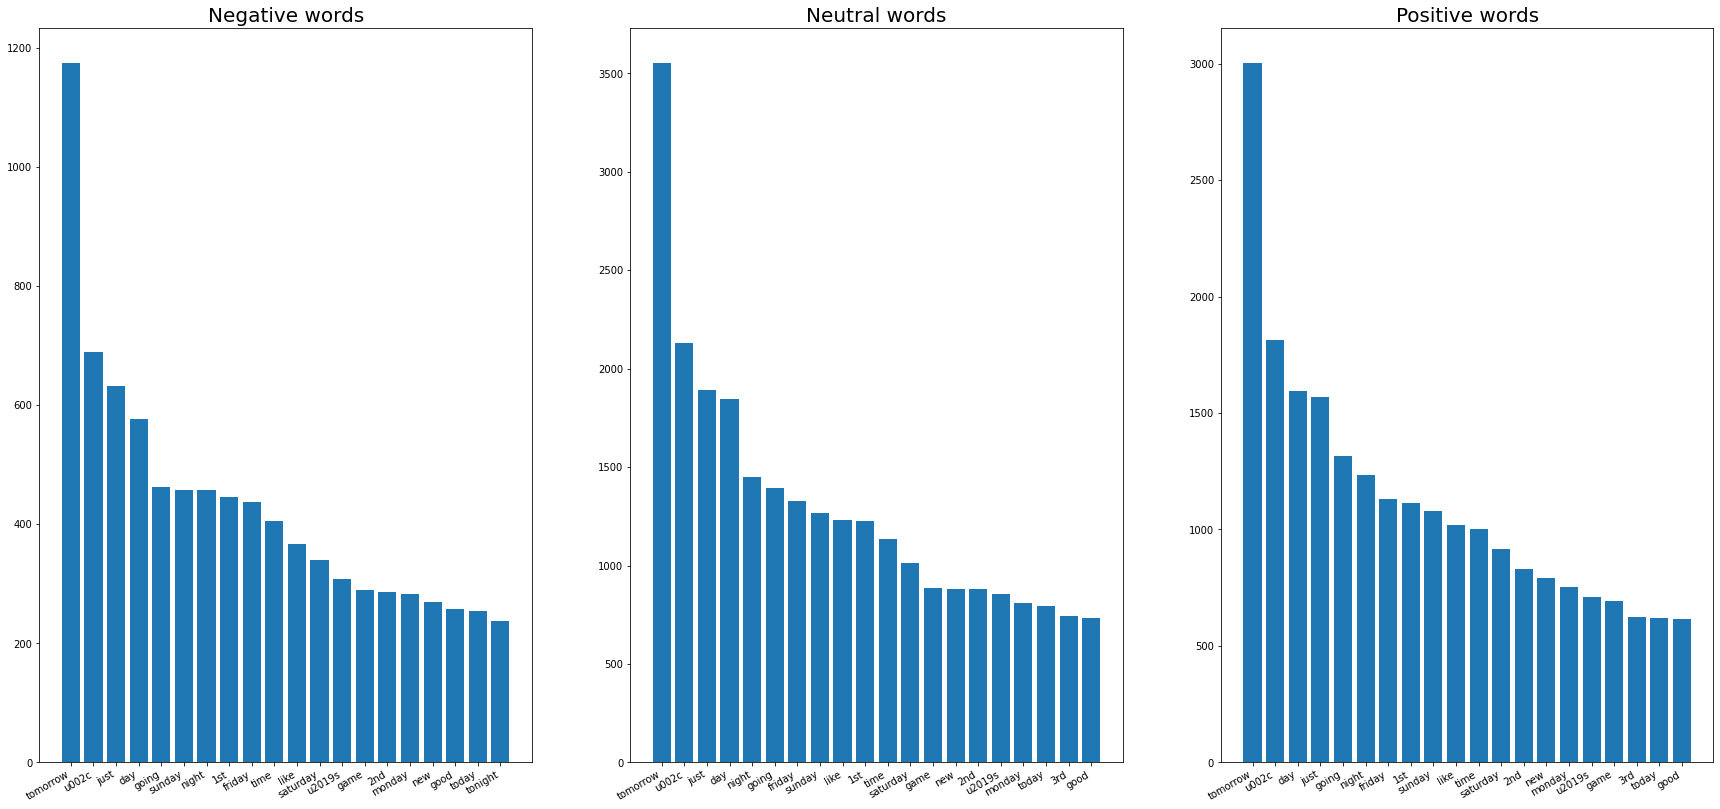

In [139]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1, 3, figsize=[30, 15])
ax1.bar(s1, s2)
ax1.set_title('Negative words',fontsize=20);
fig.autofmt_xdate()

ax2.bar(a1,a2)
ax2.set_title('Neutral words',fontsize=20);
fig.autofmt_xdate()

ax3.bar(j1,j2)
ax3.set_title('Positive words',fontsize=20);
fig.autofmt_xdate()

# **Further Work**

1. Training all 3 different models.
2. Testing the Models with micro average F1 score as evalution matrics.
3. Testing different models to achieve best average F1 score.